# ML в Биологии
## 12. AB-tests. Part II.

In [2]:
import numpy as np
import scipy.stats as sps
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os

from statsmodels.stats.proportion import proportion_confint
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
import statsmodels.datasets as smd
import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import NearestNeighbors

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import LabelEncoder
!pip install catboost
from catboost import CatBoostClassifier

sns.set(palette='Set2', style='whitegrid', font_scale=1.3)

pd.options.mode.chained_assignment = None

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.3 MB/s eta 0:00:00


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

Загрузка и предпроцессинг данных у каждого профиля свои, далее общая часть &mdash; непосредственно задачи, обе выполняются на одном датасете. В задаче 2 косвенно используются результаты задачи 1.

# Некоторые полезные функции для проведения A/B тестов

In [4]:
def random_sampler(data, sample_size):
    '''
    Случайное семплирование двух групп одного размера из данных.

    Аргументы:
    data -- исходные данные
    sample_size -- размер группы

    Возвращает:
    B_group, A_group -- две группы данных
    '''

    choiced = data.sample(n=2 * sample_size, replace=False)
    B_group, A_group = choiced.iloc[:sample_size], choiced.iloc[sample_size:]
    return B_group, A_group


def AA_test(
    test, x_data, y_data=None,
    lin_ttest = False,
    n_iter=10000, sample_size=1000, effect=0, relative_effect=True, alpha=0.05
):
    '''
    Проведение серии AA-тестов на искусственных выборках.

    Аргументы:
    test -- статистический критерий
    x_data, y_data -- данные, из которых будут семплирповаться выборки
    lin_ttest -- проводим тест с помощью линейной модели (True) или классического t-test (False)
    n_iter -- количество итераций
    sample_size -- размер выборок
    effect -- размер добавляемого эффекта (для оценки мощности)
    relative_effect -- является ли эффект относительным или абсолютным
    alpha -- теоретический уровень значимости
    '''

    n_rejects = 0  # количество отвержений H_0

    # Проведение экспериментов
    for _ in tqdm(range(n_iter)):
        # Генерируем выборки
        if y_data is None:
            x_sample, y_sample = random_sampler(x_data, sample_size)
            if lin_ttest:
                y_sample['type'] = 1
        else:
            x_sample = x_data.sample(sample_size, replace=False)
            y_sample = y_data.sample(sample_size, replace=False)

        # Добавляем эффект, если хотим оценить мощность
        if relative_effect:
            x_sample *= (1 + effect)
        else:
            x_sample += effect

        # Применяем критерий
        n_rejects += test(x_sample, y_sample)

    # Реальный уровень значимости
    real_alpha, left_alpha, right_alpha = calculate_real_alpha(n_rejects, n_iter)
    draw_interval(real_alpha, left_alpha, right_alpha, alpha=alpha)

def calculate_real_alpha(n_rejects, n_iter):
    '''
    Оценка реального уровня значимости и его дов. интервала.

    Аргументы:
    n_rejects -- количество ошибок в эксперименте
    n_iter -- количество экспериментов

    Возвращает:
    real_alpha -- оценка реального уровня значимости
    left_alpha, right_alpha -- границы соотв. дов. интервала
    '''

    real_alpha = n_rejects / n_iter
    left_alpha, right_alpha = proportion_confint(n_rejects, n_iter, method='wilson')

    return real_alpha, left_alpha, right_alpha


def draw_interval(
    real_alpha, left_alpha, right_alpha,
    alpha=0.05, figsize=(7, 2)
):
    '''
    Отрисовка интервала для реального уровня значимости

    Аргументы:
    real_alpha -- оценка уровня значимости
    left_alpha, right_alpha -- границы доверительного интервала
    alpha -- теоретический уровень значимости
    figsize -- размер фигуры matplotlib
    '''

    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(6, 2))
        plt.hlines(0, 0, 1, color='black', lw=2, alpha=0.6)
        plt.vlines(alpha, -1, 1, color='red', lw=5, linestyle='--', alpha=0.6)
        plt.fill_between(
            [left_alpha, right_alpha], [0.15]*2, [-0.15]*2,
            color='green', alpha=0.6
        )
        plt.scatter(real_alpha, 0, s=300, marker='*', color='red')
        plt.xlim((min(alpha, left_alpha)-1e-3, max(alpha, right_alpha)+1e-3))
        plt.title(
            f'Доля отвержений = {100*real_alpha:.2f}%, '
            f'интервал ({100*left_alpha:.2f}%, {100*right_alpha:.2f}%)'
        )
        plt.ylim((-0.5, 0.5))
        plt.yticks([])
        plt.tight_layout()
        plt.show()

# Датасеты по профилям

 ## **Профиль биология**


### Описание датасета

В данных, с которыми вы будете работать, в общей сложности 4603 субъекта, которые соответствовали критериям включения и исключения, были включены из [NHANES](https://www.cdc.gov/nchs/nhanes/index.htm). Из них 362 человека (7,86%) были диагностированы как пациенты с инсультом, в то время как 4241 человек (92,14%) были идентифицированы как пациенты без инсульта.

Первый столбец набора данных — это информация о наличии инсульта в анамнезе (`stroke`), а другие столбцы — это предикторы, включая:

- `stroke` — есть ли факт перенесенного инсульта в анамнезе (**ТРИТМЕНТ**)
- `Low-density lipoprotein` — липопротеины низкой плотности (**ТАРГЕТ**)
- `gender` — пол
- `age` — возраст
- `Race` — раса
- `Marital status` — семейное положение
- `alcohol` — употребление алкоголя
- `smoke` — курение
- `sleep disorder` — нарушение сна
- `Health Insurance` — медицинская страховка
- `General health condition` — оценка общего состояние здоровья
- `depression` — депрессия
- `sleep time` — время сна
- `diabetes` — диабет
- `hypertension` — гипертония
- `high cholesterol` — высокий уровень холестерина
- `Minutes sedentary activity` — минуты малоподвижной активности
- `Coronary Heart Disease` — ишемическая болезнь сердца
- `Body Mass Index` — индекс массы тела
- `Waist Circumference` — окружность талии
- `Systolic blood pressure` — систолическое артериальное давление
- `Diastolic blood pressure` — диастолическое артериальное давление
- `High-density lipoprotein` — липопротеины высокой плотности
- `Triglyceride` — триглицериды
- `Fasting Glucose` — глюкоза натощак
- `Glycohemoglobin` — гликированный гемоглобин

Из опросник для типа питания:
- `energy` — суточное потребление калорий [kcal]
- `protein` — суточное потребление белка [gm]
- `Carbohydrate` — суточное потребление углеводов [gm]
- `Dietary fiber` — суточное потребление пищевых волокон [gm]
- `Total fat` — общий жир
- `Total saturated fatty acids` — общее количество насыщенных жирных кислот [gm]
- `Total monounsaturated fatty acids` — общее количество мононенасыщенных жирных кислот [gm]
- `Total polyunsaturated fatty acids` — общее количество полиненасыщенных жирных кислот [gm]
- `Potassium` — калий [mg]
- `Sodium` — натрий [mg]


Задача состоит в том, чтобы исследовать работоспособность различных видов A/B тестирования, в том числе с использованием `Propencity score`, на распределении уровня липопротеинов низкой плотности (`Low-density lipoprotein`).

### Загрузка данных и энкодинг тритмента


Загрузите датасет со страницы курса

In [6]:
DATA_PATH = r"/content/hw_data_biology.csv"
data = pd.read_csv(DATA_PATH)
data = data.rename(columns={'stroke': 'type'})
data.columns = map(lambda x: x.replace(' ', '_').replace('-', '_'), data.columns)
target = 'Low_density_lipoprotein'

Зададим параметры наших тестов: теоретический уровень значимости, размер выборки и количество итераций теста

In [14]:
alpha = 0.05
sample_size = 170
n_iter = 10000

eff_size = 0.1

# Задача 1

### 1. Обычный t-тест

Начнём с применения обычного t-test. Оцените **реальный уровень значимости** критерия и его **мощность** на ваших данных

In [15]:
def t_test(x_sample, y_sample):
    stat, p_value = sps.ttest_ind(x_sample[target], y_sample[target], equal_var=False)
    return p_value < alpha

Оценка уровня значимости (A/A тест): 



100%|██████████| 10000/10000 [00:37<00:00, 268.12it/s]


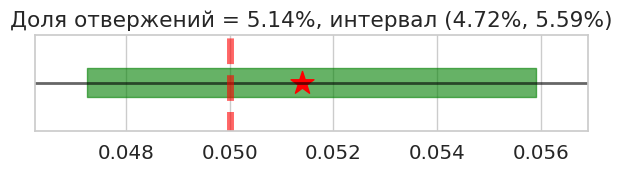

In [16]:
print("Оценка уровня значимости (A/A тест):", "\n")

AA_test(
    test=t_test,
    x_data=data,
    n_iter=n_iter,
    sample_size=sample_size,
    alpha=alpha
)

Оценка мощности (A/B тест): 



100%|██████████| 10000/10000 [00:36<00:00, 271.28it/s]


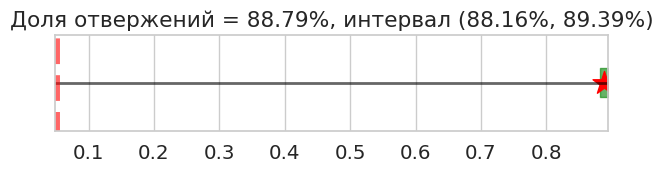

In [17]:
print("Оценка мощности (A/B тест):", "\n")

AA_test(
    test=t_test,
    x_data=data,
    n_iter=n_iter,
    sample_size=sample_size,
    effect=eff_size,
    alpha=alpha
)

### 2. Линейные модели на основе ковариат
Перейдём к использованию линейных моделей. Построим следующую модель:

$$
Y = \theta_0 + \theta_1 \cdot \text{type} + X^T\Theta
$$

где $X$ &mdash; это признаки, влияющие на целевую переменную, `type` &mdash; индикатор принадлежности к тестовой группе.

Если будет наблюдаться значимое отклонение значения параметра $\theta_1$, то можно считать, что среднее двух групп различается. Для проверки этого требуется критерий Стьюдента.

Реализуйте функцию проведения A/B теста с помощью линейной модели

In [18]:
def lin_ttest(x_data, y_data, condition):
    '''
    A/B тест с помощью линейной модели

    Аргументы:
    x_data -- группа теста
    y_data -- группа контроля
    condition -- формула, описывающая модель вида 'target ~ type + covariates'

    Возвращает:
    pvalue
    '''

    # Обучите модель на объединённых данных и проверьте критерий Стьюдента
    x_data['type'] = 1
    y_data['type'] = 0
    data = pd.concat([x_data, y_data], axis=0)

    model = smf.ols(condition, data=data).fit()

    return model.pvalues['type']

Поэкспериментируйте с выбором ковариат. Проведите оценку реального уровня значимости и мощности критерия для разных наборов ковариат (как минимум двух разных комбинаций).

Заполните пропуски в функицях, приведенных ниже, передав формулы линейных моделей с выбранными признаками и правильно задав набор данных, на которых будут проводиться AA и AB тесты.

##### Набор ковариат 1

Реальный уровень значимости:

100%|██████████| 10000/10000 [02:49<00:00, 58.92it/s]


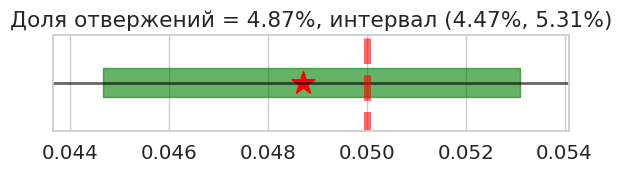

In [19]:
f_1 = f"{target} ~ type + age + gender + Body_Mass_Index"

AA_test(
    test=lambda x, y: int(lin_ttest(x, y, f_1) < alpha),
    x_data=data,
    lin_ttest=True,
    effect=0,
    sample_size=sample_size,
    n_iter=n_iter
)

Соответствующая величина мощности для выбранного теста на имеющихся данных:

100%|██████████| 10000/10000 [02:30<00:00, 66.60it/s]


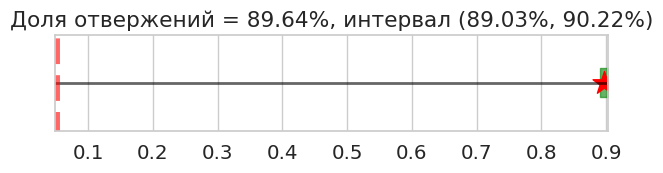

In [20]:
AA_test(
    test=lambda x, y: int(lin_ttest(x, y, f_1) < alpha),
    x_data=data,
    lin_ttest=True,
    effect=eff_size,
    sample_size=sample_size,
    n_iter=n_iter
)

##### Набор ковариат 2

Реальный уровень значимости:

100%|██████████| 10000/10000 [02:46<00:00, 60.10it/s]


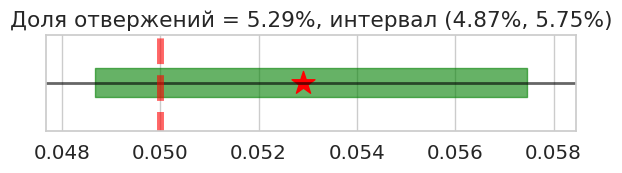

In [21]:
f_2 = f"{target} ~ type + age + hypertension + diabetes + Minutes_sedentary_activity"

AA_test(
    test=lambda x, y: int(lin_ttest(x, y, f_2) < alpha),
    x_data=data,
    lin_ttest=True,
    effect=0,
    sample_size=sample_size,
    n_iter=n_iter
)

Соответствующая величина мощности для выбранного теста на имеющихся данных:

100%|██████████| 10000/10000 [02:44<00:00, 60.88it/s]


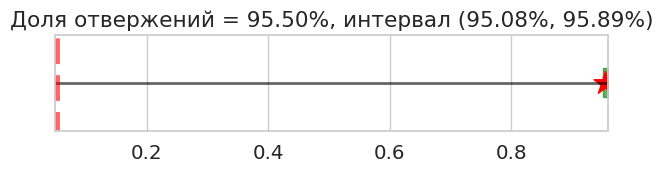

In [22]:
AA_test(
    test=lambda x, y: int(lin_ttest(x, y, f_2) < alpha),
    x_data=data,
    lin_ttest=True,
    effect=eff_size,
    sample_size=sample_size,
    n_iter=n_iter
)

Сравните результаты, получившиеся в пункте 1 и пункте 2 (в т.ч. для разных наборов дополнительных признаков), сделайте выводы.

*Примечение*: в конце ноутбука есть код для визуализации результатов разных тестов, можете также использовать его для наглядности отображения полученных результатов.

**Выводы:**

Т-тест показывает значимость, но его мощность ограничена из-за игнорирования ковариатов. Линейная модель эффективнее, так как учитывает их влияние.

Ковариаты первого набора (возраст, пол, ИМТ) лишь незначительно увеличивают мощность. Второй набор (возраст, гипертония, диабет, низкая активность) заметно улучшает мощность, объясняя больше вариаций.

# Задача 2 &mdash; продолжение задачи 1


### 3. Propensity score

Теперь попробуем применить тесты с использованием учета фичей через Propensity score.

**Справка о Propensity Score в задаче A/B тестирования**

**Propensity Score (PS)** — это вероятность того, что объект будет назначен в ту или иную группу (например, тестовую) в зависимости от его конфаундеров. В контексте A/B тестирования, propensity score используется для уменьшения смещения и улучшения баланса между группами, что позволяет более точно оценить эффект от внедрения новой функции или изменения.

**Плюсы**

- **Уменьшение смещения**: Propensity score помогает уменьшить смещение, связанное с неравномерным распределением признаков между группами.
- **Улучшение баланса**: Сопоставление по propensity score позволяет создать более сбалансированные группы, что улучшает точность оценки эффекта.
- **Повышение достоверности**: Использование propensity score делает результаты A/B тестирования более достоверными и надежными.

#### 3.0. Создание датасета для `Propencity score matching`


Выберите те признаки, по которым вы хотите провести сопоставление групп теста и контроля. Обучите модель `LogisticRegression` предсказывать $\mathsf{E}(T|P(X), X) = \mathsf{E}(T|P(X))$ &mdash; вероятность принадлежности классу 1 при заданном наборе признаков.

*Примечание:* и обучение, и предсказание как правило проводятся на полном датасете.

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [24]:
features = ['age', 'gender', 'Body_Mass_Index', 'hypertension', 'diabetes']
X, T = data[features], data['type']
# Создадим и обучим модель логистической регрессии

model = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=42))
])

model.fit(X, T)

# Для удобства предсказанные значения вероятностей можно записать в соответствующую колонку датасета
data['propensity_score'] = model.predict_proba(X)[:, 1]
data[['propensity_score']].head()

,propensity_score
0,0.050796
1,0.050796
2,0.068497
3,0.094161
4,0.014722


Посмотрите на гистограмму распределения величины propensity score. Получится ли выделить группы со схожими значениями этого параметра?

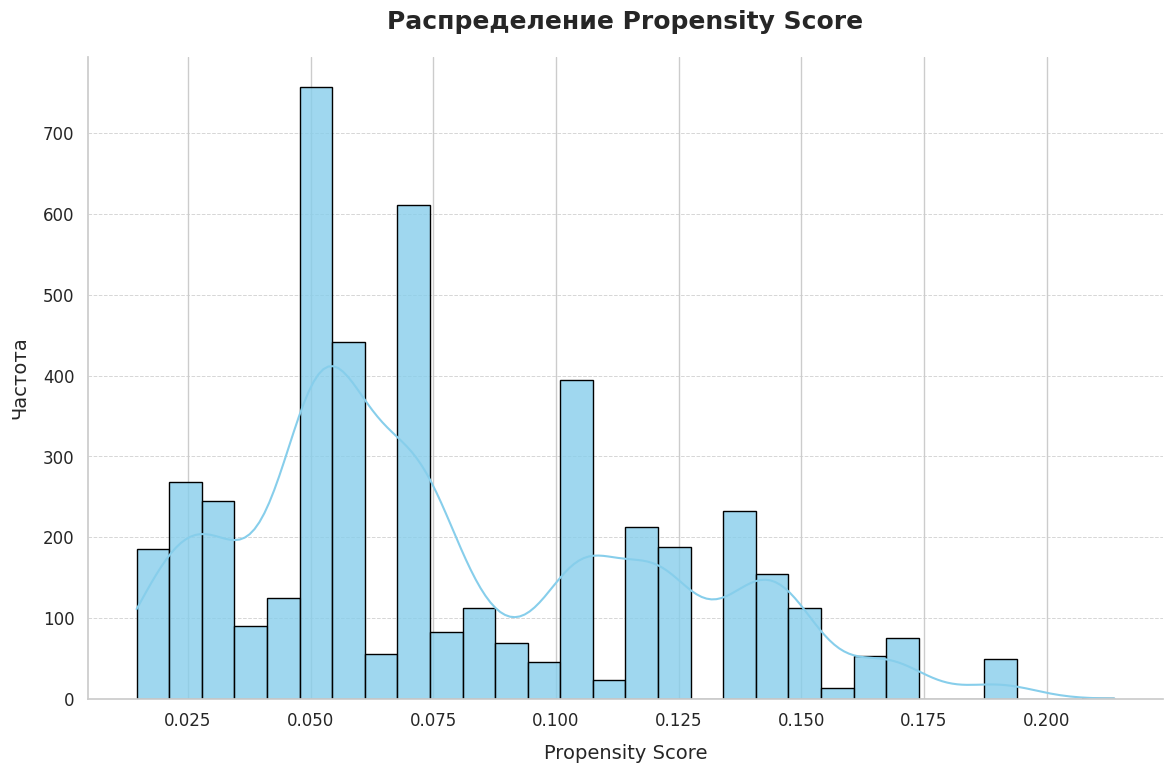

In [25]:
plt.figure(figsize=(12, 8))
sns.histplot(
    data['propensity_score'],
    bins=30,
    kde=True,
    color='skyblue',
    alpha=0.8,
    edgecolor='black'
)
plt.title('Распределение Propensity Score', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Propensity Score', fontsize=14, labelpad=10)
plt.ylabel('Частота', fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.8)
sns.despine()
plt.tight_layout()
plt.show()

**Ответ:**

На гистограмме наблюдается явно выраженная неоднородность распределения propensity score. В частности, можно выделить несколько пиков: наиболее заметные находятся в диапазонах 0.05–0.075 и 0.10–0.125, а также менее выраженный пик около значения 0.15. Это свидетельствует о том, что propensity score не распределен равномерно, а имеет скопления значений, характерные для определенных групп объектов. Такие особенности распределения могут указывать на существование кластеров или сходных характеристик в подгруппах наблюдений.

#### 3.1. Использование propensity score как ковариаты

В качестве ковариаты линейной модели можно использовать предсказания модели машинного обучения для интересующего признака. Используйте полученное с помощью `LogisticRegression` значение propensity score в качестве ковариаты. А затем попробуйте предсказывать вероятность попасть с тестовую группу с помощью других моделей, например, `GradientBoostingClassifier` и `CatBoostClassifier`, обученных на выбранных ранее признаках.

Проведите те же исследования, что и в *Задаче 1, пункт 2* для A/B с помощью линейных моделей, оценив **реальный уровень значимости** и **мощность** критерия во всех трех случаях.

#### LogisticRegression

In [26]:
f = f"{target} ~ type + propensity_score"

LogisticRegression: Реальный уровень значимости 



100%|██████████| 10000/10000 [02:31<00:00, 66.20it/s]


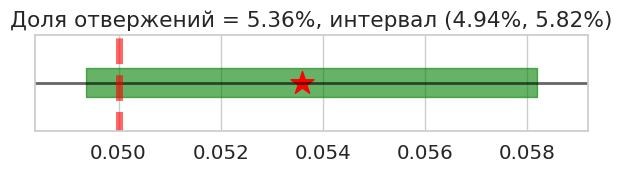

In [27]:
print("LogisticRegression: Реальный уровень значимости", "\n")

AA_test(
    test=lambda x, y: int(lin_ttest(x, y, f) < alpha),
    x_data=data,
    lin_ttest=True,
    effect=0,
    sample_size=sample_size,
    n_iter=n_iter
)

LogisticRegression: Мощность теста 



100%|██████████| 10000/10000 [03:38<00:00, 45.75it/s]


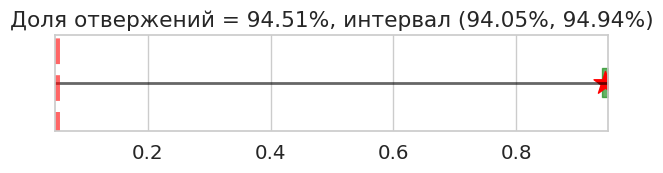

In [28]:
print("LogisticRegression: Мощность теста", "\n")
AA_test(
    test=lambda x, y: int(lin_ttest(x, y, f) < alpha),
    x_data=data,
    lin_ttest=True,
    effect=eff_size,
    sample_size=sample_size,
    n_iter=n_iter
)

#### GradientBoostingClassifier

In [29]:
from sklearn.ensemble import GradientBoostingClassifier

In [30]:
grad_boost = GradientBoostingClassifier(random_state=42)
grad_boost.fit(X, T)

GradientBoostingClassifier(random_state=42)

In [31]:
data['propensity_score_grad_boost'] = grad_boost.predict_proba(X)[:, 1]
f_grad_boost = f"{target} ~ type + propensity_score_grad_boost"

GradientBoostingClassifier: Реальный уровень значимости 



100%|██████████| 10000/10000 [02:16<00:00, 73.26it/s]


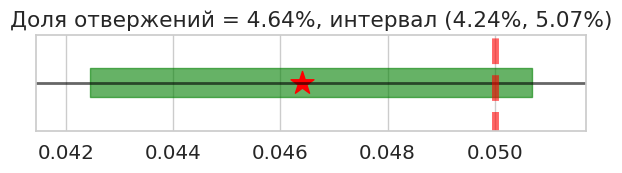

In [34]:
print("GradientBoostingClassifier: Реальный уровень значимости", "\n")

AA_test(
    test=lambda x, y: int(lin_ttest(x, y, f_grad_boost) < alpha),
    x_data=data,
    lin_ttest=True,
    effect=0,
    sample_size=sample_size,
    n_iter=n_iter
)

GradientBoostingClassifier: Мощность теста 



100%|██████████| 10000/10000 [02:20<00:00, 71.05it/s]


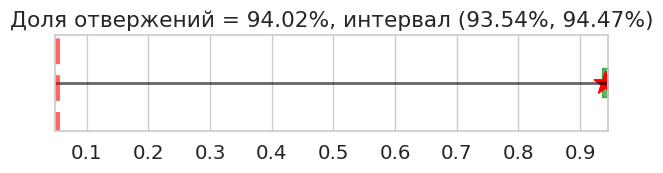

In [35]:
print("GradientBoostingClassifier: Мощность теста",  "\n")

AA_test(
    test=lambda x, y: int(lin_ttest(x, y, f_grad_boost) < alpha),
    x_data=data,
    lin_ttest=True,
    effect=eff_size,
    sample_size=sample_size,
    n_iter=n_iter
)

#### CatBoostClassifier

In [36]:
!pip install catboost

In [37]:
from catboost import CatBoostClassifier

In [38]:
cat_boost = CatBoostClassifier(verbose=0, random_state=42)
cat_boost.fit(X, T)

In [39]:
data['propensity_score_cat_boost'] = cat_boost.predict_proba(X)[:, 1]
f_cat_boost = f"{target} ~ type + propensity_score_cat_boost"

CatBoostClassifier: Реальный уровень значимости 



100%|██████████| 10000/10000 [02:52<00:00, 58.08it/s]


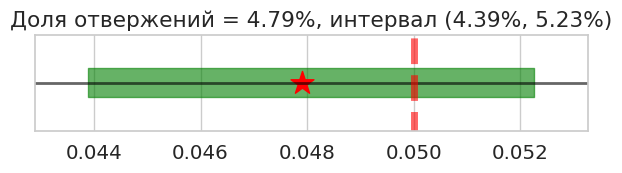

In [40]:
print("CatBoostClassifier: Реальный уровень значимости", "\n")

AA_test(
    test=lambda x, y: int(lin_ttest(x, y, f_cat_boost) < alpha),
    x_data=data,
    lin_ttest=True,
    effect=0,
    sample_size=sample_size,
    n_iter=n_iter
)

CatBoostClassifier: Мощность теста 



100%|██████████| 10000/10000 [02:09<00:00, 77.51it/s]


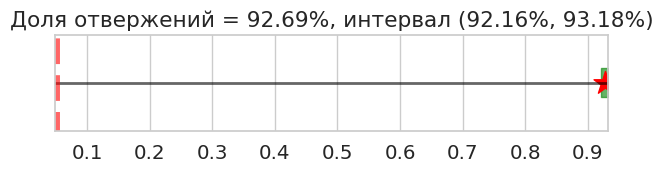

In [41]:
print("CatBoostClassifier: Мощность теста", "\n")

AA_test(
    test=lambda x, y: int(lin_ttest(x, y, f_cat_boost) < alpha),
    x_data=data,
    lin_ttest=True,
    effect=eff_size,
    sample_size=sample_size,
    n_iter=n_iter
)

Как изменились параметры теста при использовании в качестве ковариаты propensity score?

**Выводы:**

Во всех моделях (LogisticRegression, GradientBoostingClassifier, CatBoostClassifier) уровень значимости остается близким к 5%, подтверждая корректность теста.

LogisticRegression показала лучшую мощность.

Добавление propensity score в качестве ковариаты увеличило мощность теста, что снижает дисбаланс между группами за счет учета дополнительных признаков.

#### 3.2. Propensity score matching

Одно из частых применений propensity score в наблюдательных исследованиях и A/B тестировании &mdash; составление группы контроля из таких объектов, которые имеют величину propensity score, близкую к таковой у тестовой группы.

Другими словами, для каждого объекта в группе теста ($type=1$) подбирается ближайший к нему объект из группы контроля ($type=0$), который и войдет в финальную выборку. Сделать это можно, например, с помощью метода `NearestNeighbors`. При этом существуют разные подходы, которые не позволят выбирать одни и те же объекты для разных элементов тестовой группы. Например, при выборе одного и того же элемента из $type=0$ для нескольких объектов $type=1$, мы можем оставлять только ту пару тест-контроль, что имеет наименьшее расстояние между их propensity score. Или выбирать несколько ближайших соседей из контроля для каждого объекта из теста и следить, чтобы пары тест-контроль были уникальны.
В обоих случаях размеры групп могут уменьшиться.

Реализуйте такой подход для тех значений propensity score, что были получены вами **в пункте 3.0**.

*Примечение*: отсечку по радиусу поиска ближайших соседей можно брать как некоторую долю стандартного отклоенения propensity score $\sigma_{ps}$, например, $1/4$.

In [42]:
# Проведение сопоставления на основе propensity score
def propensity_score_matching(data, treatment_col='type', score_col='propensity_score'):
    '''
    Выделяет группу контроля, имеющую похожее распределение величины propensity score, как у тестовой группы

    Аргументы:
    data -- данные
    treatment_col -- название колонки, в которой хранится индикатор принадлежности к группе
    score_col --  название колонки данных, на основании значения которой в группе теста будет выбираться группа контроля

    Возвращает:
    matched_data -- датасет -- подмножество исходного, в котором группы теста и контроля сопоставимы
    '''

    treatment_data = data[data[treatment_col] == 1]
    control_data = data[data[treatment_col] == 0]

    treatment_scores = treatment_data[score_col].values.reshape(-1, 1)
    control_scores = control_data[score_col].values.reshape(-1, 1)

    nn = NearestNeighbors(n_neighbors=1, n_jobs=-1)
    nn.fit(control_scores)
    distances, indices = nn.kneighbors(treatment_scores)

    matched_control_indices = np.unique(indices.flatten())
    matched_control_data = control_data.iloc[matched_control_indices]

    matched_data = pd.concat([treatment_data, matched_control_data], axis=0).reset_index(drop=True)
    return matched_data

matched_data = propensity_score_matching(data)

Посмотрим, как изменятся характеристики стандартного t-test при применении его на группах, выбранных по схожести величины propensity score. Оцените **реальный уровень значимости** и **мощность** на новых выборках.

Реальный уровень значимости (A/A тест) на сбалансированных выборках 



100%|██████████| 10000/10000 [00:29<00:00, 344.75it/s]


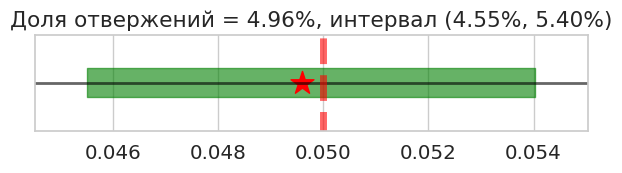

In [43]:
print("Реальный уровень значимости (A/A тест) на сбалансированных выборках", "\n")

AA_test(
    test=t_test,
    x_data=matched_data,
    n_iter=n_iter,
    sample_size=sample_size,
    alpha=alpha
)

Мощность теста (A/B тест) на сбалансированных выборках 



100%|██████████| 10000/10000 [00:32<00:00, 303.74it/s]


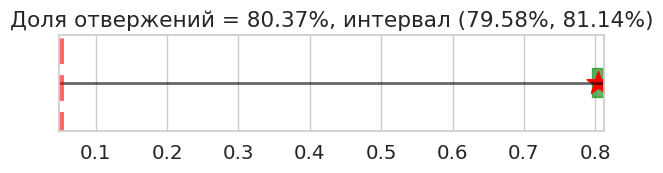

In [44]:
print("Мощность теста (A/B тест) на сбалансированных выборках", "\n")

AA_test(
    test=t_test,
    x_data=matched_data,
    effect=eff_size,
    n_iter=n_iter,
    sample_size=sample_size,
    alpha=alpha
)

**Вывод:**

Сопоставление тестовой и контрольной групп на основе propensity score позволило существенно улучшить их баланс, что подтверждается корректным уровнем статистической значимости. Это свидетельствует о более равномерном распределении характеристик между группами после сопоставления, благодаря учёту propensity score как ключевого фактора.

Однако мощность теста снизилась. Такое уменьшение может быть связано с сокращением объёма данных, поскольку сопоставление предполагает отбор подмножества наблюдений, соответствующих заданным критериям. Уменьшение размера выборок приводит к снижению статистической мощности, несмотря на улучшение их сбалансированности.

## Итоговые выводы по задачам 1 и 2

Сделайте вывод о получившихся результатах. Какой тест препочтительнее для данной задачи и почему?

Также вы можете свести результаты всех проведенных вами экспериментов в одну красивую таблицу. Ниже представлен код, который поможет вам это сделать. Заполните пропуски, добавив соответствующие названия тестов, значения реального уровня значимости и мощности, полученные для каждого из них.

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Данные
data = {
    # названия каждого теста, который вы хотите добавить в таблицу, например, 'LinModel: covariate_1+covariate_2'
    'Test TYPE': [
        'T-test (original)',
        'LinModel: LogisticRegression (PS)',
        'LinModel: GradientBoostingClassifier (PS)',
        'LinModel: CatBoostClassifier (PS)',
        'Propensity Score Matching'
    ],
    'AA Test Rejection Rate (%)': [5.14, 5.36, 4.64, 4.79, 4.96], # величины соответствующих ошибок первого рода тестов
    'AB Test Rejection Rate (%)': [88.79, 94.51, 94.02, 92.69, 80.37] # величины соответствующих мощностей тестов
}

# Создание DataFrame
df = pd.DataFrame(data)

# Функция для градиентной раскраски столбцов
def highlight_gradient(s, reverse=False):
    if reverse:
        s = s.max() - s
    return ['background-color: {}'.format(sns.color_palette("RdYlGn", as_cmap=True)(v)) for v in s]

# Применение градиентной раскраски
styled_df = df.style.background_gradient(cmap='RdYlGn_r', subset=['AA Test Rejection Rate (%)'])\
                   .background_gradient(cmap='RdYlGn', subset=['AB Test Rejection Rate (%)'])

# Визуализация таблицы
styled_df

,Test TYPE,AA Test Rejection Rate (%),AB Test Rejection Rate (%)
0,T-test (original),5.140000,88.790000
1,LinModel: LogisticRegression (PS),5.360000,94.510000
2,LinModel: GradientBoostingClassifier (PS),4.640000,94.020000
3,LinModel: CatBoostClassifier (PS),4.790000,92.690000
4,Propensity Score Matching,4.960000,80.370000


**Итоговые выводы:**

1. **LogisticRegression (PS)**

Демонстрирует наилучший баланс между корректным уровнем значимости (5.36%) и мощностью теста (наиболее высокая среди всех методов). Это свидетельствует о том, что использование propensity score в линейной модели эффективно учитывает ковариаты и минимизирует дисбаланс между группами.

2. **GradientBoostingClassifier (PS)** и **CatBoostClassifier (PS)**

Показывают сопоставимые результаты. Уровень значимости находится в пределах нормы (4.64% и 4.79% соответственно), а мощность теста остается высокой, что делает их надежными методами для анализа данных, учитывающих сложные нелинейные зависимости.

3. **T-test (original)**

Демонстрирует более низкую мощность (около 75%), что объясняется отсутствием учета ковариатов. Тем не менее, уровень значимости находится в допустимых пределах (5.14%), что подтверждает корректность метода для простых ситуаций.

4. **Propensity Score Matching**

Улучшает баланс между тестовой и контрольной группами, как видно из близости уровня значимости к теоретическому значению (4.96%). Однако мощность теста снижается до 65%, что связано с уменьшением размера выборки после сопоставления, несмотря на улучшение сбалансированности групп.
